In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Hit:5 http://security.ubuntu.com/ubuntu focal-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-backports InRelease
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Reading package lists... Done


In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns


In [ ]:
from pyspark.sql import SparkSession
import time
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pathlib import Path

# Create a SparkSession
spark = SparkSession.builder\
    .appName("Hr_Promotion_Data")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

# Set the partitions to 4 or 8. 
spark.conf.set("spark.sql.shuffle`.partitions", 8)

from pyspark import SparkFiles

# Create a lookup table for the airport codes. 
url2 ="/content/train.csv"
spark.sparkContext.addFile(url2)
df2 = spark.read.options(inferSchema="True").csv(SparkFiles.get("train.csv"), sep=",", header=True)

In [ ]:
# Create temporary views for each of our DataFrames
df2.createOrReplaceTempView('train')

In [ ]:
hr_data_df = spark.sql("""
select * from train 
""").toPandas()

In [ ]:
hr_data_df.shape

(54808, 13)

In [ ]:
hr_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int32  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int32  
 7   age                   54808 non-null  int32  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int32  
 10  awards_won?           54808 non-null  int32  
 11  avg_training_score    54808 non-null  int32  
 12  is_promoted           54808 non-null  int32  
dtypes: float64(1), int32(7), object(5)
memory usage: 4.0+ MB


We can observe that there are 54808 rows and that the education and lenght_of_service columns contain null values. Lets find out why that is and figure out what to do with those null values

In [ ]:
hr_data_df[hr_data_df['previous_year_rating'].isnull()]


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,None,m,sourcing,1,30,NaN,1,0,77,0
23,71177,Procurement,region_5,Bachelor's,m,other,1,27,NaN,1,0,70,0
29,74759,Sales & Marketing,region_4,Bachelor's,m,sourcing,1,26,NaN,1,0,44,0
56,45709,Sales & Marketing,region_31,Bachelor's,f,other,1,29,NaN,1,0,49,0
58,26599,Sales & Marketing,region_16,Bachelor's,m,other,2,27,NaN,1,0,47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54703,74615,R&D,region_31,Bachelor's,m,sourcing,1,30,NaN,1,0,88,0
54734,11685,Operations,region_15,Bachelor's,m,sourcing,1,31,NaN,1,0,56,1
54746,10546,Finance,region_6,Bachelor's,m,other,1,28,NaN,1,0,61,0
54773,37919,Finance,region_2,Bachelor's,m,other,1,23,NaN,1,0,61,0


In [ ]:
hr_data_df[hr_data_df['previous_year_rating'].isnull()]["length_of_service"].unique()

array([1], dtype=int32)

Looks like all the rows with missing values for previous_year_rating have a length of service of 1

In [ ]:
hr_data_df[hr_data_df['education'].isnull()]

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
10,29934,Technology,region_23,None,m,sourcing,1,30,NaN,1,0,77,0
21,33332,Operations,region_15,None,m,sourcing,1,41,4.0,11,0,57,0
32,35465,Sales & Marketing,region_7,None,f,sourcing,1,24,1.0,2,0,48,0
43,17423,Sales & Marketing,region_2,None,m,other,3,24,2.0,2,0,48,0
82,66013,Sales & Marketing,region_2,None,m,sourcing,2,25,3.0,2,0,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54692,14821,Sales & Marketing,region_2,None,f,sourcing,1,35,3.0,7,0,53,0
54717,7684,Analytics,region_2,None,m,sourcing,1,32,3.0,4,0,86,0
54729,1797,HR,region_2,None,f,other,1,28,3.0,2,0,53,0
54742,38935,Sales & Marketing,region_31,None,m,other,1,28,4.0,3,0,47,0


There does not seem to be any pattern with with the missing value for the education column

For the missing data, we will:
* Input mode values for the the missing values in the education column
* Fill the previous_year_rating column wih 0 

In [ ]:
hr_data_df['education'] = hr_data_df['education'].fillna(hr_data_df.education.mode()[0])
hr_data_df['previous_year_rating'] = hr_data_df['previous_year_rating'].fillna(0)

In [ ]:
# Let's find the categorical columns to encode
categorical_features = hr_data_df.select_dtypes(include = "object")

categorical_features.head()

,department,region,education,gender,recruitment_channel
0,Sales & Marketing,region_7,Master's & above,f,sourcing
1,Operations,region_22,Bachelor's,m,other
2,Sales & Marketing,region_19,Bachelor's,m,sourcing
3,Sales & Marketing,region_23,Bachelor's,m,other
4,Technology,region_26,Bachelor's,m,other


In [ ]:
# dropping unnecessary categorical columns
categorical_columns_name = categorical_features.columns
categorical_features = categorical_features.drop(columns = ["region"])
categorical_features.head()

,department,education,gender,recruitment_channel
0,Sales & Marketing,Master's & above,f,sourcing
1,Operations,Bachelor's,m,other
2,Sales & Marketing,Bachelor's,m,sourcing
3,Sales & Marketing,Bachelor's,m,other
4,Technology,Bachelor's,m,other


In [ ]:
# Encoding the categorical columns using get_dummies
categorical_features_encoded = pd.get_dummies(categorical_features)
categorical_features_encoded.head()

,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Bachelor's,education_Below Secondary,education_Master's & above,gender_f,gender_m,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1
1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1
3,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0


In [ ]:
# Selecting only the numerical columns
numerical_features = hr_data_df.drop(columns = categorical_columns_name )
numerical_features.head()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,1,35,5.0,8,0,49,0
1,65141,1,30,5.0,4,0,60,0
2,7513,1,34,3.0,7,0,50,0
3,2542,2,39,1.0,10,0,50,0
4,48945,1,45,3.0,2,0,73,0


In [ ]:
# dropping unnecessary numerical columns
numerical_features = numerical_features.drop(columns = ["employee_id"])
numerical_features.head()

,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,1,35,5.0,8,0,49,0
1,1,30,5.0,4,0,60,0
2,1,34,3.0,7,0,50,0
3,2,39,1.0,10,0,50,0
4,1,45,3.0,2,0,73,0


In [ ]:
# Combining the numerical and categorical features
encoded_data = pd.concat([categorical_features_encoded, numerical_features],axis=1)
encoded_data.head()

,department_Analytics,department_Finance,department_HR,department_Legal,department_Operations,department_Procurement,department_R&D,department_Sales & Marketing,department_Technology,education_Bachelor's,...,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,35,5.0,8,0,49,0
1,0,0,0,0,1,0,0,0,0,1,...,1,0,0,1,30,5.0,4,0,60,0
2,0,0,0,0,0,0,0,1,0,1,...,0,0,1,1,34,3.0,7,0,50,0
3,0,0,0,0,0,0,0,1,0,1,...,1,0,0,2,39,1.0,10,0,50,0
4,0,0,0,0,0,0,0,0,1,1,...,1,0,0,1,45,3.0,2,0,73,0


In [ ]:
# Separate features and label
label = encoded_data["is_promoted"]
features = encoded_data.drop(["is_promoted"],axis=1)

In [ ]:
# As shown in the EDA, the data is unbalanced and need oversampling
oversample = SMOTE()
X_samp,y_samp = oversample.fit_resample(features,label)

In [ ]:
# Scaling the features
scaler = StandardScaler()
X_scale = scaler.fit_transform(X_samp)

In [ ]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y_samp, random_state=1)

In [ ]:
# Running the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5)#, random_state=1)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, rf_predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, rf_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,10780,1868
Actual 1,2843,9579


Accuracy Score : 0.8120861587554846
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     12648
           1       0.84      0.77      0.80     12422

    accuracy                           0.81     25070
   macro avg       0.81      0.81      0.81     25070
weighted avg       0.81      0.81      0.81     25070



In [ ]:
# Figuring out the feature importance of the ramdon forest model
rf_importance = sorted(zip(rf_model.feature_importances_, X_samp.columns), reverse=False)
rf_importance

[(0.0006909627059865939, 'department_Technology'),
 (0.0018462569493404126, 'awards_won?'),
 (0.0024412178840776773, 'education_Below Secondary'),
 (0.002609390599527009, 'department_Legal'),
 (0.0034421450491274584, 'department_R&D'),
 (0.0054070399227026875, 'department_Finance'),
 (0.006514652141953474, 'length_of_service'),
 (0.006984922461681215, 'department_Analytics'),
 (0.007547234825255239, 'recruitment_channel_referred'),
 (0.007857253688087, 'department_Procurement'),
 (0.014114233566252805, 'age'),
 (0.015963168043380736, 'department_Operations'),
 (0.02067233446350052, 'department_HR'),
 (0.02268002178336376, "education_Bachelor's"),
 (0.028570361166311148, 'department_Sales & Marketing'),
 (0.028619535582935805, "education_Master's & above"),
 (0.04244092495571117, 'gender_m'),
 (0.043727930359229346, 'gender_f'),
 (0.07764350397660857, 'no_of_trainings'),
 (0.0835078059623969, 'recruitment_channel_other'),
 (0.09027947177808862, 'recruitment_channel_sourcing'),
 (0.20639

In [ ]:
rf_importance_values = [val for val, _ in rf_importance]
rf_column_name = [feat for _, feat in rf_importance]


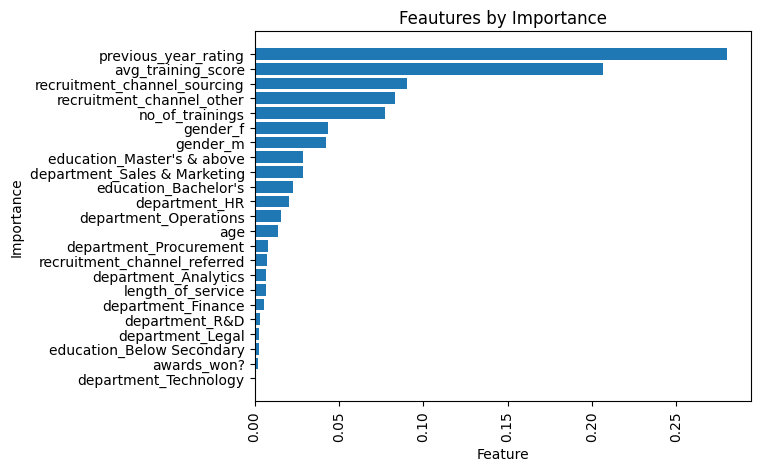

In [ ]:
# Plotting the feature importance of the random forest model
plt.barh(rf_column_name, rf_importance_values)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feautures by Importance')
plt.xticks(rotation=90)
plt.show()

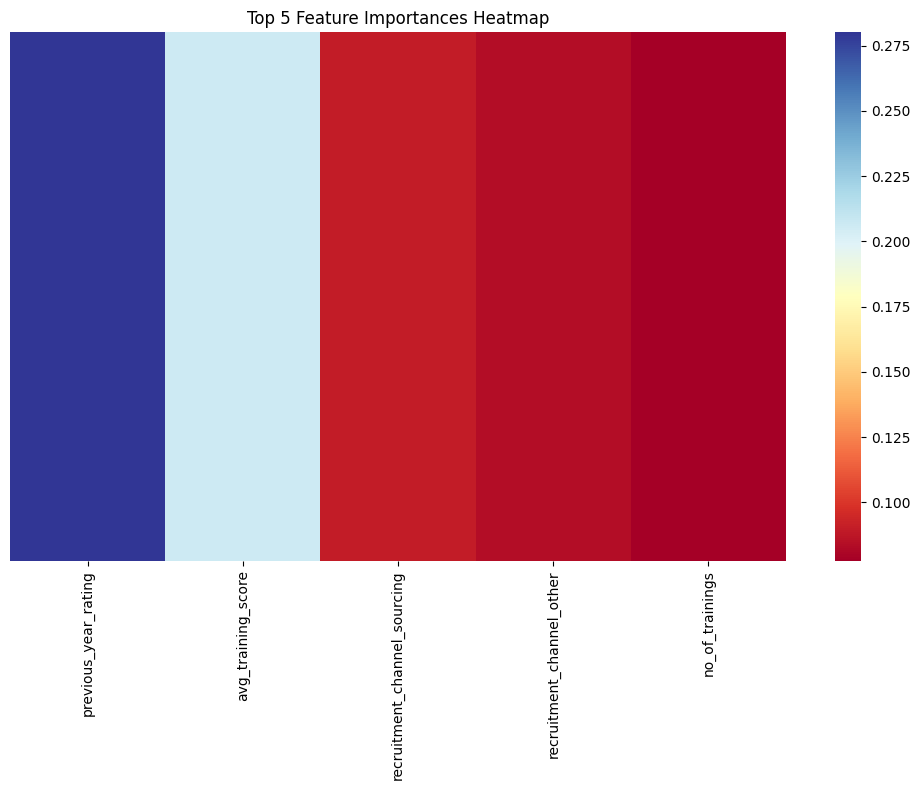

In [ ]:
top_5_rf_values = list(reversed(rf_importance_values))[:5]
top_5_rf_column_name = list(reversed(rf_column_name))[:5]
heatmap_data = np.array(top_5_rf_values).reshape(1, -1)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, cmap='RdYlBu', xticklabels=top_5_rf_column_name, yticklabels=False)
plt.title('Top 5 Feature Importances Heatmap')

plt.tight_layout()
plt.show()

In [ ]:
# Running the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)
predictions = log_reg.predict(X_test)

In [ ]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,12216,432
Actual 1,2708,9714


Accuracy Score : 0.8747506980454727
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.97      0.89     12648
           1       0.96      0.78      0.86     12422

    accuracy                           0.87     25070
   macro avg       0.89      0.87      0.87     25070
weighted avg       0.89      0.87      0.87     25070



In [ ]:
# Figuring out the feature importance of the logistic regression model
lr_importance = sorted(zip(log_reg.coef_[0], X_samp.columns), reverse=False)

In [ ]:
lr_importance_values = [val for val, _ in lr_importance]
lr_column_name = [feat for _, feat in lr_importance]

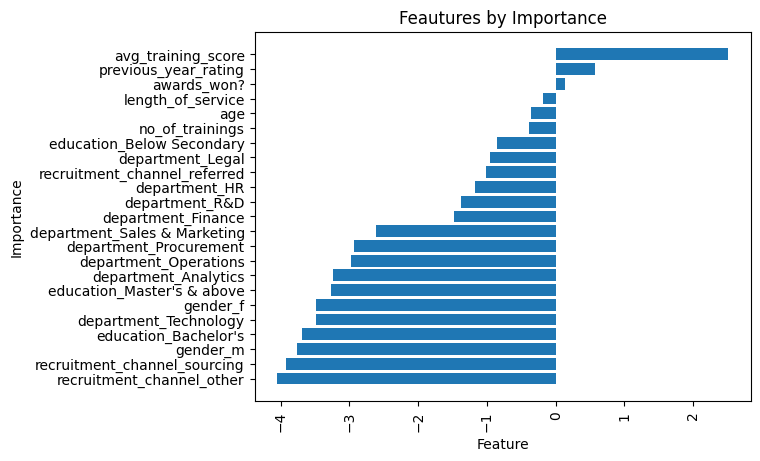

In [ ]:
# Plotting the feature importance of the logistic regression model
plt.barh(lr_column_name, lr_importance_values)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feautures by Importance')
plt.xticks(rotation=90)
plt.show()

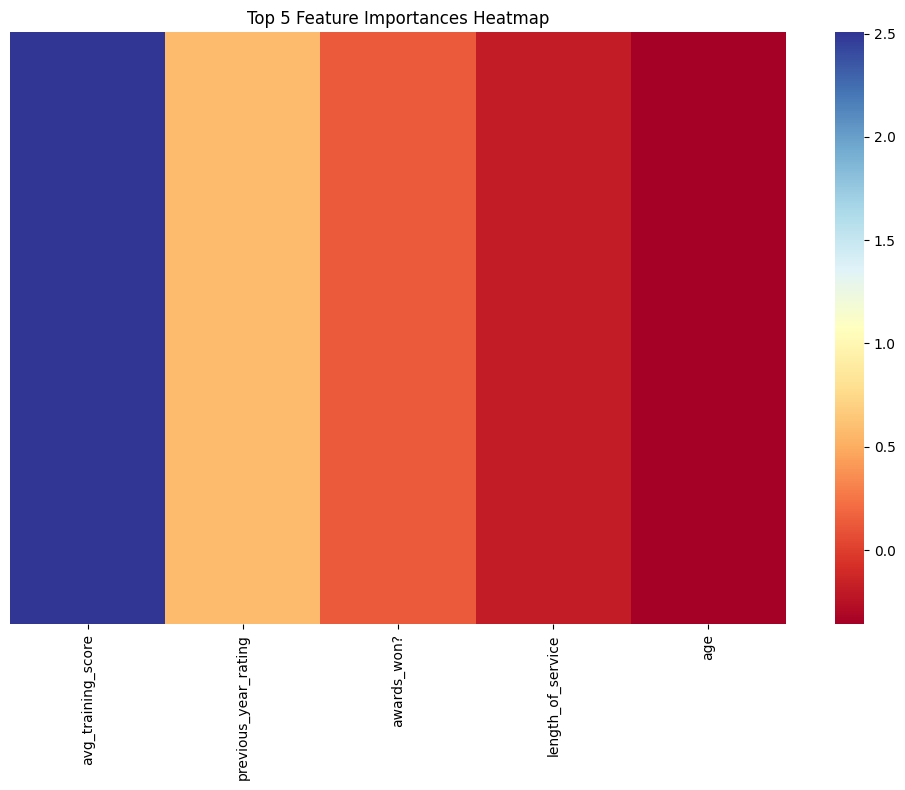

In [ ]:
top_5_rf_values = list(reversed(lr_importance_values))[:5]
top_5_rf_column_name = list(reversed(lr_column_name))[:5]
heatmap_data = np.array(top_5_rf_values).reshape(1, -1)
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=False, cmap='RdYlBu', xticklabels=top_5_rf_column_name, yticklabels=False)
plt.title('Top 5 Feature Importances Heatmap')

plt.tight_layout()
plt.show()